## Predict "New Poly" EoS

In [1]:
import os
import sys
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.model_selection import train_test_split
plt.rcParams.update({'font.size': 20})

2023-02-06 21:58:08.492591: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


### 1. Load data from file and prepare for training

Load the parameters ($X$) and the log-likelihood ($Y$) from processed data files.

In [2]:
# Load the un-normalized data
X = np.loadtxt('../data/pars.txt')
Y = np.loadtxt('../data/wgt.txt')

print("dim(Y) =", Y.shape[0])
print("dim(X) =", X.shape[0], "x", X.shape[1])

dim(Y) = 4842
dim(X) = 4842 x 91


Next, normalize the data and perform a train-test-validation split as 80-15-5.

In [3]:
# Normalize the data
x = (X - np.min(X)) / (np.max(X) - np.min(X))
y = (Y - np.min(Y)) / (np.max(Y) - np.min(Y))

# Perform train-test-validation split: 80-15-5
x_tr, x_tv, y_tr, y_tv = train_test_split(x, y, test_size=0.2, random_state=41)
x_ts, x_vl, y_ts, y_vl = train_test_split(x_tv, y_tv, test_size=0.25, random_state=41)

### 2. Build DNN Model or load model from file

Construct a deep-learning neural network (DNN). The architecture and the hyperparameters of the DNN are chosen using `keras_tuner` to optimize for performance and accuracy (see `search/random_np.ipynb`). 

In [85]:
# Load model from file
#model = load_model("../output/model_3p.h5")

# Build model from scratch
model = keras.Sequential([
    layers.Dense(364, input_shape=(91,), activation='relu'),
    layers.Dense(455, activation='relu'),
    layers.Dense(182, activation='relu'),
    layers.Dense(1, activation='linear')])

model.compile(loss='mse', optimizer='adam')
model.summary()

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_41 (Dense)            (None, 364)               33488     
                                                                 
 dense_42 (Dense)            (None, 455)               166075    
                                                                 
 dense_43 (Dense)            (None, 182)               82992     
                                                                 
 dense_44 (Dense)            (None, 1)                 183       
                                                                 
Total params: 282,738
Trainable params: 282,738
Non-trainable params: 0
_________________________________________________________________


### 3. Set up callbacks and training parameters

Set values of training parameters: batch size and number of epochs. Also, create optional callbacks such as early stopping and saving weights with checkpointings. 

In [86]:
batch_size = 128
num_epochs = 2000

# Set up a callback to stop early if given criteria is satisfied
stop_early = tf.keras.callbacks.EarlyStopping(monitor='loss', min_delta=1.0e-8, patience=40)

# Setup checkpointing
ckpt_path = "../ckpts/eos_np.ckpt"
ckpt_dir = os.path.dirname(ckpt_path)

# Set up another callback that saves the model's weights
save_weights = tf.keras.callbacks.ModelCheckpoint(filepath=ckpt_path, save_weights_only=True, verbose=0)

Skip to left side bar
>
/train/
Name
Last Modified

### 4. Fit model and save training history

Train the DNN using training and testing data. Note that we still have unobserved validation data left to be used later for further testing and predicting EoS.

In [87]:
training = model.fit(x=x_tr, y=y_tr, batch_size=batch_size, validation_data=(x_ts, y_ts), \
                    epochs=num_epochs, callbacks=[stop_early, save_weights], verbose=2)

Epoch 1/2000
31/31 - 1s - loss: 0.0476 - val_loss: 0.0171 - 885ms/epoch - 29ms/step
Epoch 2/2000
31/31 - 0s - loss: 0.0159 - val_loss: 0.0168 - 128ms/epoch - 4ms/step
Epoch 3/2000
31/31 - 0s - loss: 0.0153 - val_loss: 0.0165 - 122ms/epoch - 4ms/step
Epoch 4/2000
31/31 - 0s - loss: 0.0153 - val_loss: 0.0164 - 132ms/epoch - 4ms/step
Epoch 5/2000
31/31 - 0s - loss: 0.0151 - val_loss: 0.0166 - 121ms/epoch - 4ms/step
Epoch 6/2000
31/31 - 0s - loss: 0.0152 - val_loss: 0.0162 - 123ms/epoch - 4ms/step
Epoch 7/2000
31/31 - 0s - loss: 0.0149 - val_loss: 0.0162 - 120ms/epoch - 4ms/step
Epoch 8/2000
31/31 - 0s - loss: 0.0149 - val_loss: 0.0163 - 124ms/epoch - 4ms/step
Epoch 9/2000
31/31 - 0s - loss: 0.0148 - val_loss: 0.0157 - 121ms/epoch - 4ms/step
Epoch 10/2000
31/31 - 0s - loss: 0.0148 - val_loss: 0.0155 - 119ms/epoch - 4ms/step
Epoch 11/2000
31/31 - 0s - loss: 0.0146 - val_loss: 0.0153 - 122ms/epoch - 4ms/step
Epoch 12/2000
31/31 - 0s - loss: 0.0145 - val_loss: 0.0152 - 124ms/epoch - 4ms/step


### 5. Check training results

Examine how well the network was trained by evaluating the model (i.e. computing the loss function) on the validation data and looking into the training history. Keep an eye on the order of magnitude of the loss function and any evidence of overfitting or underfitting. 

In [88]:
loss = model.evaluate(x_vl, y_vl, verbose=0)
print("Loss = {:.4e}".format(loss))

Loss = 1.0800e-02


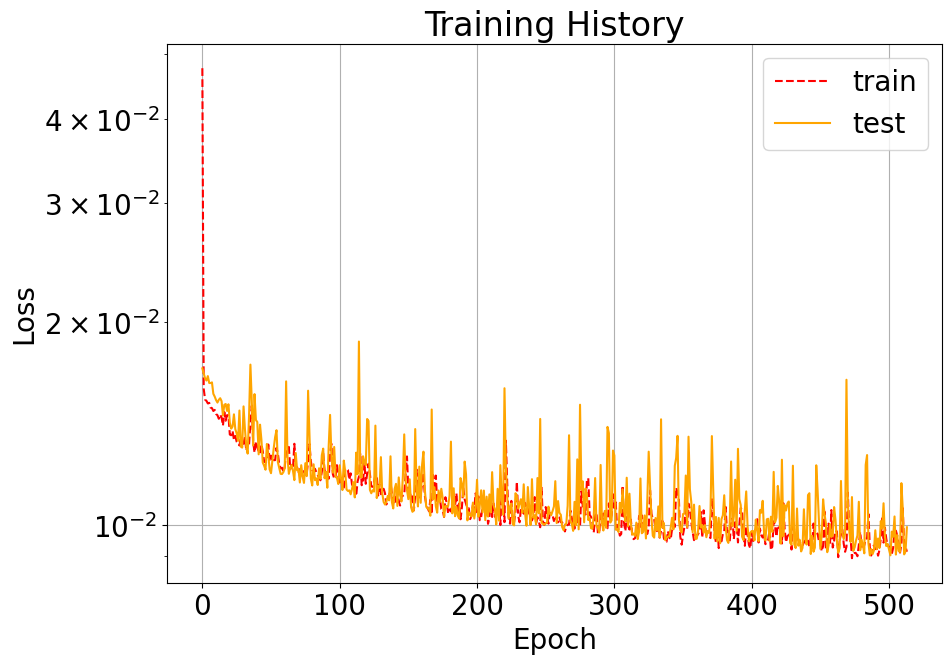

In [89]:
plt.figure(figsize=(10,7))
plt.semilogy(training.history['loss'], ls='--', color='red', label='train')
plt.semilogy(training.history['val_loss'], color='orange', label='test')
plt.grid()
plt.ylabel("Loss")
plt.xlabel("Epoch")
plt.title("Training History")
plt.legend()
plt.show()

### 6. Predict log-likelihood and compare with data

Evaluate model with validation data and de-normalize data and prediction.

In [90]:
x = x_vl
y = y_vl
pd = np.array(model(x))

# De-normalize data and prediction
pr = np.min(Y) + (np.max(Y) - np.min(Y)) * pd
dt = np.min(Y) + (np.max(Y) - np.min(Y)) * y

Choose a random $M-R$ curve and predict the corresponding EoS. Plot the predicted EoS and the data for comparison.

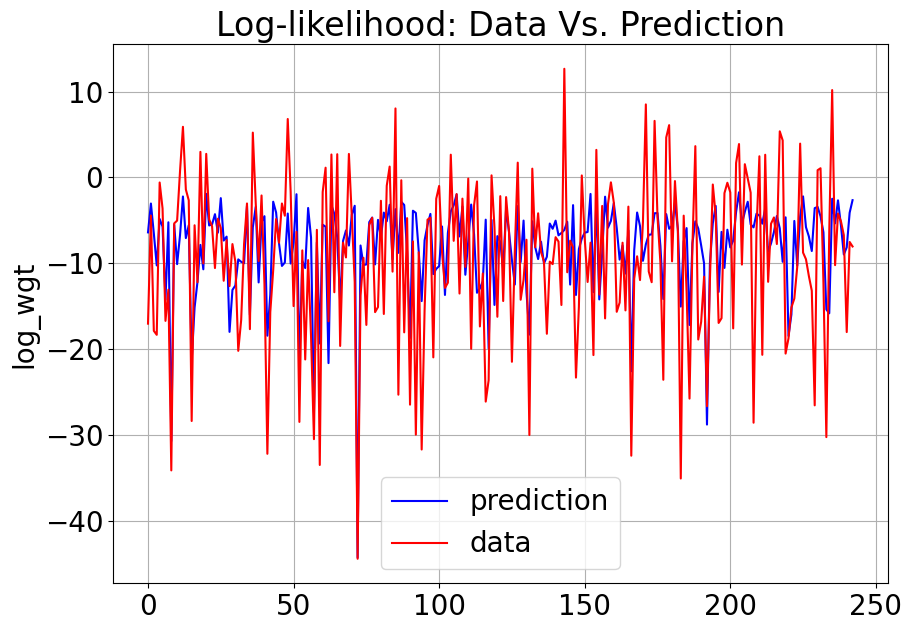

In [91]:
#i = np.random.choice(x_vl.shape[0])

plt.figure(figsize=(10,7))
plt.plot(pr, color='blue', label='prediction')
plt.plot(dt, color='red', label='data')

plt.title("Log-likelihood: Data Vs. Prediction")
plt.ylabel("log_wgt")
plt.legend()
plt.grid()
#plt.savefig(f"{FIGS}/real_vs_models.png")
plt.show()